## Document Clustering with LLM Embeddings (AG News)

- **Dataset:** AG News (HuggingFace), 4 news categories.
- **Embeddings:** `sentence-transformers/all-MiniLM-L6-v2` – a modern sentence embedding model.
- **Pipeline:**
  1. Load text documents and true labels.
  2. Compute dense vector embeddings using the LLM-based model.
  3. Apply **K-Means** clustering in embedding space (k=4).
  4. Evaluate clustering quality using:
     - **Silhouette score** (unsupervised).
     - **Adjusted Rand Index (ARI)** against true news categories (for reference).
  5. Inspect example documents per cluster to interpret cluster topics.
  6. Visualize clusters in 2D using PCA.
- **Observation:** Documents with similar topics (e.g., sports, business, world news) are grouped together in the high-dimensional embedding space, showing the power of LLM embeddings for semantic clustering.

In [1]:
!pip install -q datasets
!pip install -q sentence-transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA


In [ ]:
# Load AG News from HuggingFace
dataset = load_dataset("ag_news")

# Use only the training split and take a subset to keep it fast
train_ds = dataset["train"]
df = train_ds.to_pandas()

# Keep only needed columns
df = df[["text", "label"]]

# Take a subset, e.g., first 2000 documents
N = 2000
df = df.iloc[:N].reset_index(drop=True)

print(df.head())
print("\nNumber of documents:", len(df))
print("Unique labels:", df["label"].unique())


In [3]:
texts = df["text"].tolist()
y_true = df["label"].values  # 0–3 (4 news categories)

print("Example document:")
print(texts[0])


Example document:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [ ]:
# Use a state-of-the-art sentence embedding model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

# Compute embeddings for all documents
embeddings = embedder.encode(
    texts,
    batch_size=64,
    show_progress_bar=True
)

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


In [5]:
# AG News has 4 topics, so we set k=4
k = 4

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

print("Cluster labels (first 20):", cluster_labels[:20])
print("Unique clusters:", np.unique(cluster_labels))


Cluster labels (first 20): [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
Unique clusters: [0 1 2 3]


In [6]:
sil = silhouette_score(embeddings, cluster_labels)
ari = adjusted_rand_score(y_true, cluster_labels)

print("Silhouette Score (embeddings space):", sil)
print("Adjusted Rand Index (vs true AG News labels):", ari)


Silhouette Score (embeddings space): 0.036675923
Adjusted Rand Index (vs true AG News labels): 0.34558648228089484


In [7]:
def show_examples_for_cluster(df, cluster_labels, cluster_id, n=5):
    print(f"\n=== Cluster {cluster_id} examples ===")
    idxs = np.where(cluster_labels == cluster_id)[0][:n]
    for i in idxs:
        print(f"\n[Doc {i}] True label: {df.loc[i, 'label']}")
        print(df.loc[i, "text"][:300].replace("\n", " ") + " ...")

for c in range(k):
    show_examples_for_cluster(df, cluster_labels, c, n=3)



=== Cluster 0 examples ===

[Doc 3] True label: 2
Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday. ...

[Doc 15] True label: 2
Rescuing an Old Saver If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon. ...

[Doc 19] True label: 2
Shell 'could be target for Total' Oil giant Shell could be bracing itself for a takeover attempt, possibly from French rival Total, a  press report claims. ...

=== Cluster 1 examples ===

[Doc 0] True label: 2
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. ...

[Doc 1] True label: 2
Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\wh

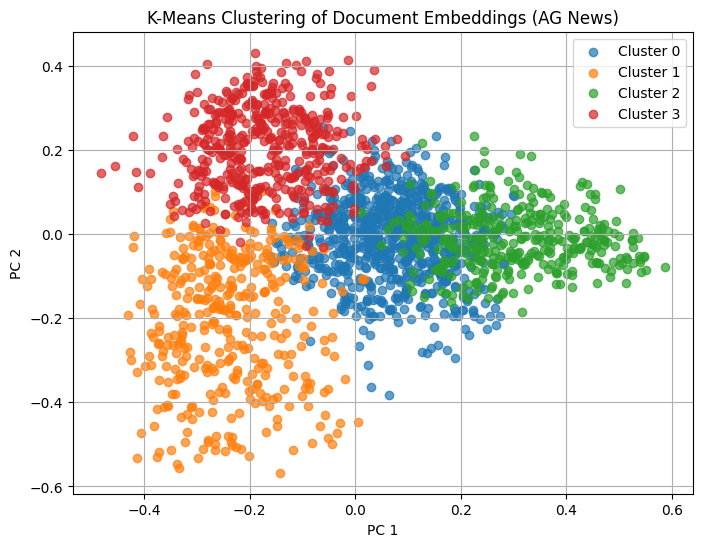

In [8]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for c in range(k):
    mask = cluster_labels == c
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        alpha=0.7,
        label=f"Cluster {c}"
    )

plt.title("K-Means Clustering of Document Embeddings (AG News)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


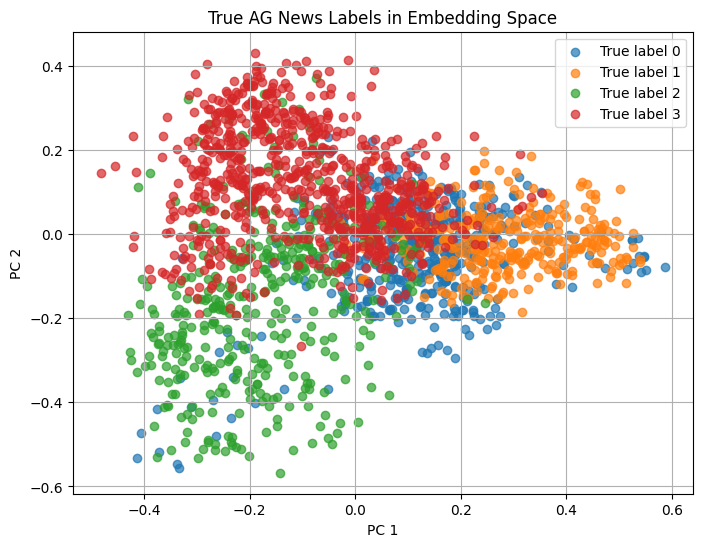

In [10]:
plt.figure(figsize=(8, 6))
for label in np.unique(y_true):
    mask = y_true == label
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        alpha=0.7,
        label=f"True label {label}"
    )

plt.title("True AG News Labels in Embedding Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


## Document Clustering with LLM Embeddings (AG News)

- **Dataset:** AG News (HuggingFace), 4 news categories.
- **Embeddings:** `sentence-transformers/all-MiniLM-L6-v2` – a modern sentence embedding model.
- **Pipeline:**
  1. Load text documents and true labels.
  2. Compute dense vector embeddings using the LLM-based model.
  3. Apply **K-Means** clustering in embedding space (k=4).
  4. Evaluate clustering quality using:
     - **Silhouette score** (unsupervised).
     - **Adjusted Rand Index (ARI)** against true news categories (for reference).
  5. Inspect example documents per cluster to interpret cluster topics.
  6. Visualize clusters in 2D using PCA.
- **Observation:** Documents with similar topics (e.g., sports, business, world news) are grouped together in the high-dimensional embedding space, showing the power of LLM embeddings for semantic clustering.
